In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
#3D dataset
np.random.seed(4)
m=60
w1,w2=0.1,0.3
noise=0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
#PCA using SVD decomposition
X_centered = X - X.mean(axis=0)
U,s,Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:,0]
c2 = Vt.T[:,1]
c2

array([-0.34027485,  0.90119108,  0.2684542 ])

In [4]:
m,n = X.shape

S = np.zeros(X_centered.shape) 
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
#using sklearn to reduce dimentionality is PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [9]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [10]:
#SVD gives same result as PCA,just axes are flipped
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
#Variance ratio
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

This output tells you that 84.2% of the dataset’s variance lies along the first PC, and 14.6% lies along the second PC. This leaves less than 1.2% for the third PC, so it is reasonable to assume that the third PC probably carries little information.

In [15]:
import urllib.request
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    mnist.target = mnist.target.astype(np.int64)
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

In [16]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [17]:
#choosing the right number of dimension
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum>=0.95)+1
d

154

In [19]:
#this is same as upper
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [22]:
pca.n_components_

154

In [24]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [25]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


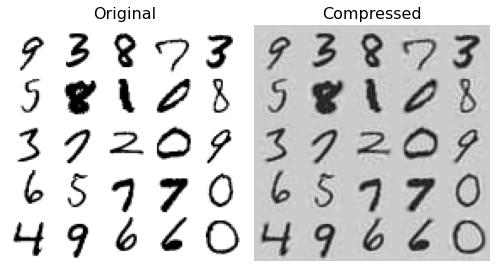

In [26]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [31]:
#Incremental PCA
from sklearn.decomposition import IncrementalPCA

n_batches=100
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)


IncrementalPCA(batch_size=525, n_components=154)

Load the MNIST dataset (introduced in Chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing). Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set. Next, use PCA to reduce the dataset’s dimensionality, with an explained variance ratio of 95%. Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster? Next, evaluate the classifier on the test set. How does it compare to the previous classifier?

In [32]:
from sklearn.datasets import fetch_openml
    
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.int64)

In [33]:
X_train = mnist["data"][:60000]
y_train = mnist["target"][:60000]

X_test = mnist["data"][60000:]
y_test = mnist["target"][60000:]

In [34]:
#RandomForestClassifier alg
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=10,random_state=42)

In [35]:
import time

t0 = time.time()
rnd_clf.fit(X_train,y_train)
t1=time.time()

In [54]:
print("Training time for RandomForestClassifier {:.2f}s".format(t1-t0))

Training time for RandomForestClassifier 2.88s


In [37]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.9492

In [38]:
#PCA for reducing dimentionality
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_trained_reduced = pca.fit_transform(X_train)

In [41]:
rnd_clf2 = RandomForestClassifier(n_estimators=10,random_state=42)

t0 = time.time()
rnd_clf2.fit(X_trained_reduced,y_train)
t1=time.time()

In [55]:
print("Training time for RandomForestClassifier after dimention reduction {:.2f}s".format(t1-t0))

Training time for RandomForestClassifier after dimention reduction 2.88s


Training time actually increased rather than decreased. Always dimentionality eduction doesnt lessen time. It sometimes depends on the dataset and applied algorithm

In [44]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9009

In [46]:
#LogisticRegression alg
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42)
t0 = time.time()
log_clf.fit(X_train,y_train)
t1=time.time()

/Users/swatikar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [56]:
print("Training time for LogisticRegression {:.2f}s".format(t1-t0))

Training time for LogisticRegression 2.88s


In [48]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [50]:
log_clf2 = LogisticRegression(random_state=42)
t0 = time.time()
log_clf2.fit(X_trained_reduced, y_train)
t1 = time.time()

/Users/swatikar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [58]:
print("Training time for LogisticRegression after dimention reduction {:.2f}s".format(t1-t0))

Training time for LogisticRegression after dimention reduction 2.88s


This time it is 2 times faster than before

In [59]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201